## Large area analysis
combine the classification and object detection into one whole by applying them both on large areas
The idea is displayed here: https://www.nature.com/articles/s41598-019-50795-9


In [43]:
# imports
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from glob import glob
import json
import numpy as np
from pprint import pprint
import cv2
import copy
import sys

# sys path workaround
sys.path.insert(0, "../..")
from classification.models.densenet import build_densenet121


from keras_yolov2.preprocessing import parse_annotation_xml, parse_annotation_csv, parse_annotation_tfr
from keras_yolov2.utils import get_session, create_backup, draw_boxes
from keras_yolov2.frontend import YOLO

## Load data paths and mixers
the data paths to the compressed large area files and mixer files
The large area is composed of several image patches. The mixer file tells you how many patches there are, and how many patches per row you have so you can reconstruct the image

In [15]:
data_path = '../../datasets/testlocations/'
aoi = 'china1'
aoi_path = glob(data_path + aoi + '*.gz')
mixer_file_path = glob(data_path + aoi + '*.json')

with open(mixer_file_path[0]) as data:
    mixer = json.load(data)

# Print the mixer image data
print(mixer)

{'projection': {'crs': 'EPSG:4326', 'affine': {'doubleMatrix': [8.983152841195215e-05, 0.0, 118.5848040260498, 0.0, -8.983152841195215e-05, 31.929448964159036]}}, 'patchDimensions': [257, 257], 'patchesPerRow': 10, 'totalPatches': 90}


In [16]:
# parsing TFRecord file

def predict_input_fn(fileNames, side, bands):
  
    # Read `TFRecordDatasets` 
    dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')

    featuresDict = {x:tf.io.FixedLenFeature([side, side], dtype=tf.float32) for x in bands}
    #print(featuresDict)
    # Make a parsing function
    def parse_image(example_proto):
        parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
        return parsed_features
    
    def stack_images(features):   
        channels = ['B4', 'B3', 'B2' ,'MNDWI', 'AVE']
        img_chan = [features[x] for x in channels if x in ['B4', 'B3', 'B2' ]]
        ndwi_chan = [features[x] for x in channels if x in ['MNDWI']]
        ave_chan = [features[x] for x in channels if x in ['AVE']]
        img = tf.transpose(tf.squeeze(tf.stack(img_chan)))
        # further normalization?
        img = tf.concat([img, tf.transpose(ndwi_chan)], axis= 2)
        
        ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
        img = tf.concat([img, tf.transpose(ave_chan)], axis= 2)

        return img
    

    dataset = dataset.map(parse_image, num_parallel_calls=4)
    dataset = dataset.map(stack_images, num_parallel_calls=4) 
    #CAHNGE THIS TO TOTAL_PATCHES * PATCH PER ROW
    dataset = dataset.batch(200)

    return dataset

In [17]:
image_batch_mapper = predict_input_fn(aoi_path, 257, ['B4', 'B3', 'B2','MNDWI','AVE'])

# cast it into an np array
for x in image_batch_mapper:
    images = x.numpy()
    

## Create models
configure the model, set the parameters.
The routine is as follows. First, a patch will be classified using a trained classifier. In our case, this is another CNN (DenseNet).

If the classification tells us there is a dam in the patch with a high probability ( > 0.5, but can be set by the user to a different number), the object detector will try and locate the dams in the image.

One of the drawbacks of using the object detector without the classification first, is that it will generate quite many false positives. That is why the classification model comes in handy

### Create classification model

In [54]:
params = {'channels': ['B2','B3','B4', 'AVE','MNDWI'], 'num_classes':2}
class_model = build_densenet121(**params)

# load the weights to the pretrained network
class_model.load_weights('')

instantiated with random weights
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputlayer_0 (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, None, None, 5 0           inputlayer_0[0][0]               
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 15680       zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
___________________________________________________________

NameError: name 'class_models' is not defined

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for 

### Create object detector

In [18]:
with open('config.json') as config_buffer:
    config = json.loads(config_buffer.read())
    
pprint(config)    



{'backup': {'backup_path': '../backup',
            'backup_prefix': 'Tiny_yolo_VOC',
            'create_backup': False,
            'redirect_model': False},
 'model': {'anchors': [0.03502,
                       0.05837,
                       0.06615,
                       0.03113,
                       0.08949,
                       0.07004,
                       0.15953,
                       0.13619,
                       0.36576,
                       0.31907],
           'backend': './keras_yolov2/custom_backend.DenseNet121CustomFeature',
           'gray_mode': False,
           'input_size_c': 5,
           'input_size_h': 257,
           'input_size_w': 257,
           'labels': ['dam'],
           'max_box_per_image': 10},
 'parser_annotation_type': 'tfr',
 'train': {'batch_size': 10,
           'callback': None,
           'class_scale': 0,
           'coord_scale': 1.0,
           'debug': False,
           'early_stop': False,
           'learning_rate': 0.0002,


In [19]:
yolo = YOLO(backend=config['model']['backend'],
            input_size=(config['model']['input_size_h'], config['model']['input_size_w'], config['model']['input_size_c']),
            labels=config['model']['labels'],
            max_box_per_image=config['model']['max_box_per_image'],
            anchors=config['model']['anchors'],
            gray_mode=config['model']['gray_mode'])

yolo.load_weights('trained_weights/t5fullYolo_custom_backend_custom_anchors_with_csigmoid_bestMap.h5')

loading backend weights
Unable to load backend weights. Using a fresh model
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer_0 (InputLayer)    [(None, 257, 257, 5)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 257, 257, 3)       18        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
Total params: 7,037,522
Trainable params: 6,953,874
Non-trainable params: 83,648
_________________________________________________________________
Using a custom backend called custom_backend.DenseNet121CustomFeature.
(8, 8)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 257, 257, 5)]     0         
_____

## Visualize the image

29722050
1.0


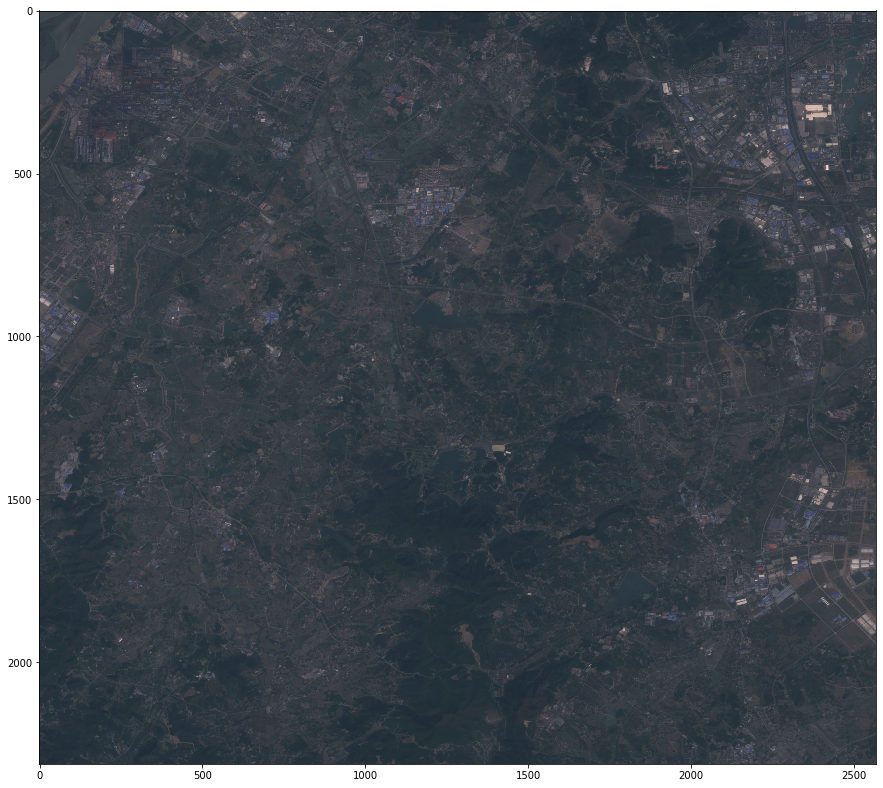

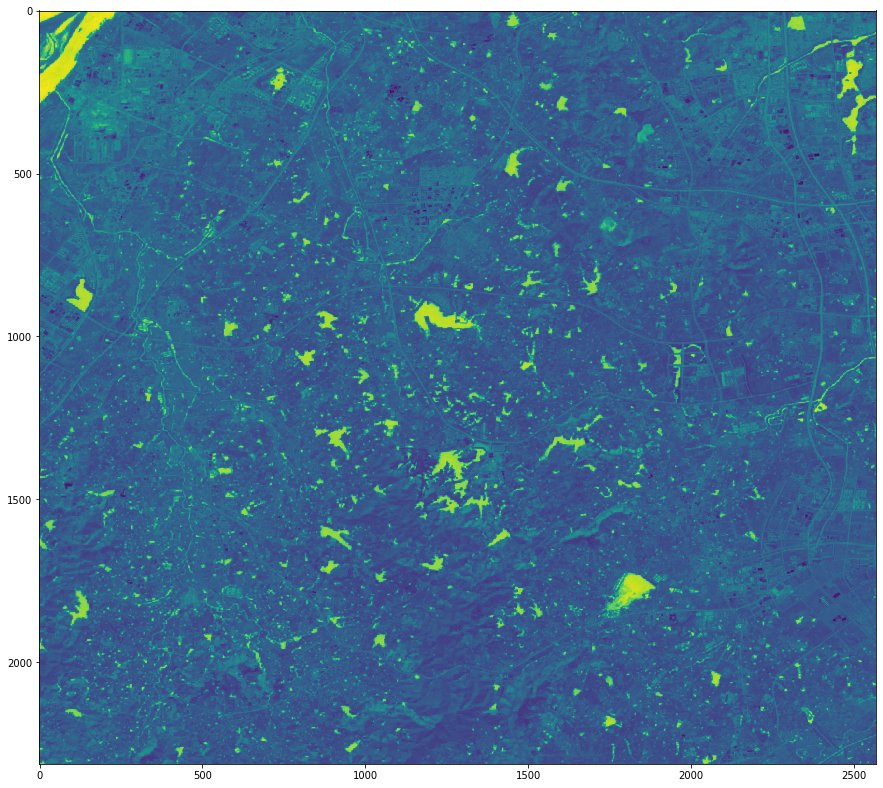

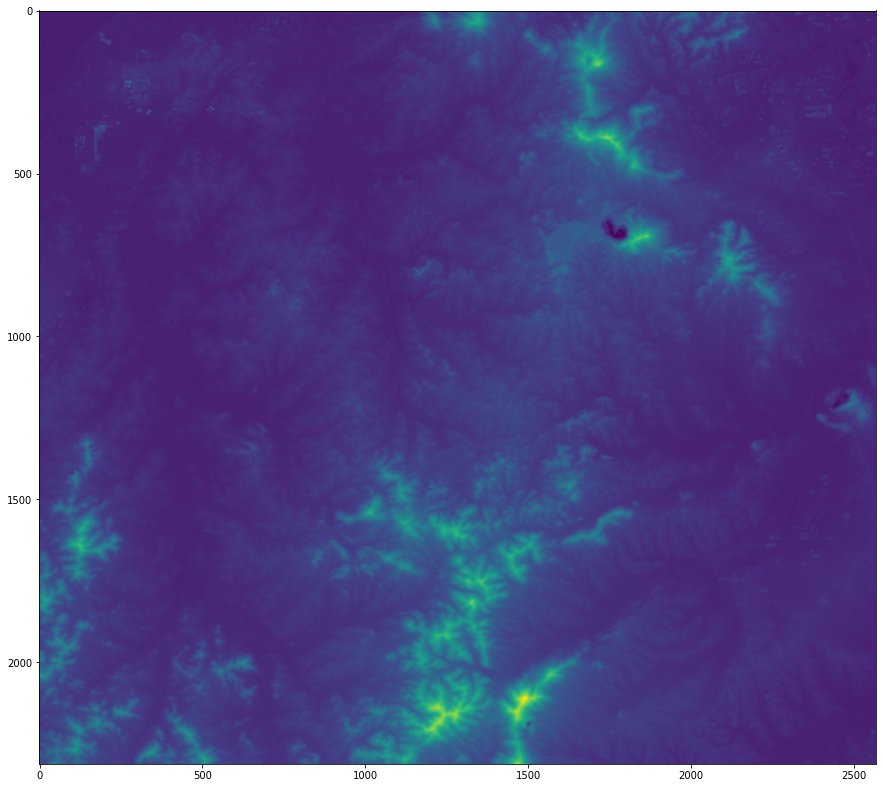

In [21]:
def stretch_image_colorspace(img):
    max_val = np.max(img)
    return img / max_val

def stitch_patches(image, mixer_dict):
    
    patch_size = mixer_dict['patchDimensions'][0]
    n_cols = mixer_dict['patchesPerRow']
    n_rows = int(mixer_dict['totalPatches'] / n_cols)
    
    shapes = image.shape
    
    #print(patch_size, n_cols, n_rows)
    fullData = np.zeros([patch_size*n_cols, patch_size*n_rows, 5])
    for n in range(0,5):
        dataMat = np.zeros([patch_size*n_cols, patch_size*n_rows])
        z = 0
        for j in range(0,n_rows):
            for i in range(0,n_cols):
                #print("datamat shape", dataMat[i*256: (i+1)*256, j*256: (j+1)*256 ].shape)
                #print("i", i)
                #print("j", j)
                dataMat[i*patch_size: (i+1)*patch_size, j*patch_size: (j+1)*patch_size ] = np.squeeze(image[z, :, :, n])
                z += 1
        fullData[:,:,n] = dataMat

    fullData[:,:,0:3] = np.transpose(np.array([fullData[:,:,0], fullData[:,:,1], fullData[:,:,2]]), (1, 2 ,0))
    return fullData


full_image = stitch_patches(images, mixer)

#RGB channels
plt.figure(figsize=(15,15))
full_image[:,:,0:3] = stretch_image_colorspace(full_image[:,:,0:3])
plt.imshow(np.fliplr(np.rot90(full_image[:,:,0:3], k=3)))

# Water index
plt.figure(figsize=(15,15))
print(full_image.size)
plt.imshow(np.fliplr(np.rot90(full_image[:,:,3], k=3)), cmap='viridis', interpolation='nearest')

# ave channel
plt.figure(figsize=(15,15))
plt.imshow(np.fliplr(np.rot90(full_image[:,:,4], k=3)), cmap='viridis', interpolation='nearest')
print(np.max(full_image))

## Algorithm for passing image patches 
1. Set the patch size, which will be used as input to the object detector model specified above
2. Set the sliding window step size in pixels, this allows for overlapping windows.

If step_size = patch_size, there will be no overlap

In [36]:
patch_size = 257
step_size = 128

shapes = full_image.shape
print(shapes)
# in order to exactly generate patches of patch_size at the edges, we need to reshape the image

# row remainder
rem_row = (shapes[0] - patch_size) % step_size
rem_col = (shapes[1] - patch_size) % step_size

# resize a bit so we can make a sliding window generator with perfect overlap in patches of patch_size
test_img = cv2.resize(full_image, (shapes[0] - rem_row, shapes[1] - rem_col))

(2570, 2313, 5)


In [37]:
#yields patches of 256 x 256



def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    print(image.shape[0])
    print(image.shape[1])

    
    for y in range(0, image.shape[0] - windowSize[0] + stepSize , stepSize):
        for x in range(0, image.shape[1]- windowSize[1] + stepSize, stepSize):
            # yield the current window
            window = image[y:y + windowSize[1], x:x + windowSize[0]].copy()
            preds = process_slide(window)
            if preds:
                print(preds)
                window = draw_boxes(window[:,:,0:3].copy(), preds, config['model']['labels'])
                image[y:y + windowSize[1], x:x + windowSize[0], 0:3] = window
            
    return image
            

def process_slide(window):
    
    # create a temporary copy (something strange happens with preprocessing if you don't)
    temp_window = window.copy()
    # preprocess the window
    temp_window[:,:,0:3] = stretch_image_colorspace(temp_window[:,:,0:3])
    preds = yolo.predict(temp_window)
    return preds

new_img = sliding_window(full_image, step_size, (patch_size, patch_size))      

2570
2313
[<BoundBox(0.48717849099048766, 0.516507020018188, 0.4184587982807629, 0.4643061329958908, 0, 1.0)>
]
[<BoundBox(0.6517505096784769, 0.7360713005570113, 0.03987204627562046, 0.12761563589621067, 0, 1.0)>
, <BoundBox(0.4891854139245882, 0.5143773863006964, 0.4625721977635933, 0.5198545821281982, 0, 1.0)>
]
[<BoundBox(0.4764474262964069, 0.5383818996142684, 0.4779631060000587, 0.513370921904676, 0, 1.0)>
]
[<BoundBox(0.4499260312695375, 0.5306813547451368, 0.4774571810962165, 0.5102285201550926, 0, 1.0)>
]
[<BoundBox(0.47367419611792927, 0.5348018603740251, 0.4786967222854735, 0.5050895996001603, 0, 1.0)>
]
[<BoundBox(0.47972935568221003, 0.5329561612439909, 0.47904712424229384, 0.5045224437708735, 0, 1.0)>
]
[<BoundBox(0.47857297421386297, 0.5306924232392555, 0.47948037405740274, 0.509296022891512, 0, 1.0)>
]
[<BoundBox(0.4888085402072875, 0.5154390234841315, 0.47156826809060887, 0.5145509867687257, 0, 1.0)>
]
[<BoundBox(0.47804113343151594, 0.5287891418972829, 0.4733398161069

[<BoundBox(0.49882706097435847, 0.5233457424933899, 0.4361344997166661, 0.5148660886251001, 0, 1.0)>
]


In [38]:
new_img.shape


(2570, 2313, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


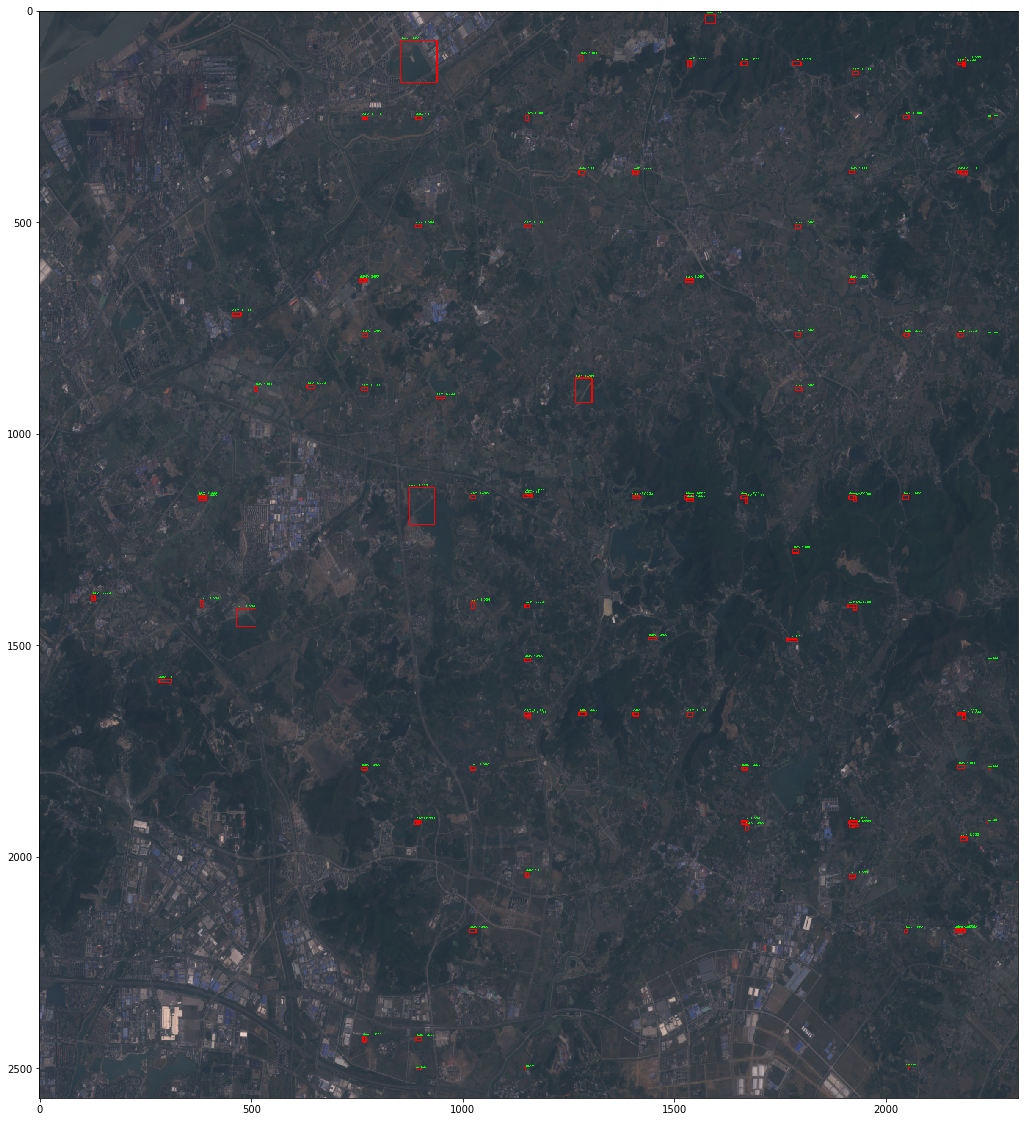

In [39]:
plt.figure(figsize=(20,20))
plt.imshow(full_image[:,:,0:3])